In [1]:
from GammaSimulations import GammaSimulations
import torch
import numpy as np

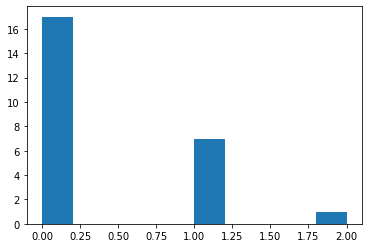

In [2]:
nr_components=25
nr_timepoints=50
nr_neurons=50
X=GammaSimulations().simulate_data(nr_components,nr_timepoints,nr_neurons)


In [3]:
U=np.zeros((nr_neurons,nr_components))
U=torch.tensor(U,requires_grad=True)
V=np.zeros((nr_components,nr_timepoints))
V=torch.tensor(V,requires_grad=True)
def forward(U,V):
    pred=U@V

In [4]:
U=torch.randn((nr_neurons,nr_components),requires_grad=True)
V=torch.randn((nr_components,nr_timepoints),requires_grad=True)
print(V)
print(U)

tensor([[ 1.5317, -0.8789, -0.3044,  ..., -0.8769, -1.7898, -1.5760],
        [ 0.7948,  0.3355,  0.9260,  ...,  0.3442,  0.9874,  0.1262],
        [ 0.8318, -1.6527,  0.0230,  ...,  1.5588, -1.7002,  1.8052],
        ...,
        [ 0.1139, -0.5214, -0.6159,  ..., -0.0650,  0.0774, -2.7786],
        [-0.1600,  0.3919,  1.1426,  ..., -1.7806, -0.6753, -0.5046],
        [-0.6630,  1.9471,  1.2255,  ...,  1.5098,  0.3425, -0.1440]],
       requires_grad=True)
tensor([[ 1.6846,  0.2410,  1.2868,  ..., -0.0880, -0.0597, -1.3190],
        [-1.6590, -1.4059,  0.0248,  ..., -0.4636,  0.6457,  1.6751],
        [-0.6774,  1.6490, -1.0414,  ...,  0.3609, -2.2637,  0.6661],
        ...,
        [ 0.0445,  1.1002, -0.1459,  ...,  0.0930, -1.2909,  1.9094],
        [ 0.6625, -0.1309,  0.2460,  ...,  0.5638,  0.5563, -0.0400],
        [-1.3606,  0.2419,  0.3053,  ...,  1.0757,  0.0797,  1.7173]],
       requires_grad=True)


In [10]:
from torch.autograd import Variable

def model(U,V):
    UV=U@V
    UV=Variable(UV,requires_grad=True)
    return UV
print((U@V).shape)
print(X.shape)
X_torch=torch.tensor(X,dtype=torch.double)
print(X_torch.shape)
def mse(t1,t2):
    diff=t1-t2
    print(diff)
    return torch.sum(diff*diff)/diff.numel()

loss_func = torch.nn.MSELoss()
U=Variable(U,requires_grad=True)
V=Variable(V,requires_grad=True)
X_torch=Variable(X_torch)
print(U)
print(V)
optimizer = torch.optim.SGD([U,V], 
                            lr=1e-6)
for i in range(0,10):
    preds=model(U,V)
    loss=loss_func(preds,X_torch)
    print(loss)
    #loss.backward()
    loss.backward()
    #print('bom',loss.backward())
    print('LOZZ',loss)
    print(U.grad)
    optimizer.step()
        

torch.Size([50, 50])
(50, 50)
torch.Size([50, 50])
tensor([[ 1.6846,  0.2410,  1.2868,  ..., -0.0880, -0.0597, -1.3190],
        [-1.6590, -1.4059,  0.0248,  ..., -0.4636,  0.6457,  1.6751],
        [-0.6774,  1.6490, -1.0414,  ...,  0.3609, -2.2637,  0.6661],
        ...,
        [ 0.0445,  1.1002, -0.1459,  ...,  0.0930, -1.2909,  1.9094],
        [ 0.6625, -0.1309,  0.2460,  ...,  0.5638,  0.5563, -0.0400],
        [-1.3606,  0.2419,  0.3053,  ...,  1.0757,  0.0797,  1.7173]],
       requires_grad=True)
tensor([[ 1.5317, -0.8789, -0.3044,  ..., -0.8769, -1.7898, -1.5760],
        [ 0.7948,  0.3355,  0.9260,  ...,  0.3442,  0.9874,  0.1262],
        [ 0.8318, -1.6527,  0.0230,  ...,  1.5588, -1.7002,  1.8052],
        ...,
        [ 0.1139, -0.5214, -0.6159,  ..., -0.0650,  0.0774, -2.7786],
        [-0.1600,  0.3919,  1.1426,  ..., -1.7806, -0.6753, -0.5046],
        [-0.6630,  1.9471,  1.2255,  ...,  1.5098,  0.3425, -0.1440]],
       requires_grad=True)


RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #2 'target'

In [28]:
import torch
import torch.nn as nn

class NMF(nn.Module):
    def __init__(self, nr_neurons, nr_timepoints, nr_components):
        super(NMF, self).__init__()
        self.U = nn.Parameter(torch.rand(nr_neurons, nr_components, requires_grad=True))
        self.V = nn.Parameter(torch.rand(nr_components, nr_timepoints, requires_grad=True))

    def forward(self):
        return torch.matmul(self.U, self.V)

# some data cube Y: B x N and we want to factor it into K components
nr_components=25
nr_timepoints=50
nr_neurons=50
#Y = torch.rand(B,N) 
X_torch=torch.tensor(X,dtype=torch.float32)
Y=X_torch
nmf = NMF(nr_neurons, nr_timepoints, nr_components)
Y_ = nmf()
loss_fn = nn.MSELoss(reduction='sum')
loss = loss_fn(Y_, Y)
loss.backward()
print(loss)
n_epoch=10
for epoch in range(n_epoch):
    Y_ = nmf()
    loss = loss_fn(Y_, Y)
    nmf.zero_grad() # need to clear the old gradients
    loss.backward()

    for param in nmf.parameters():
        param.data = param.data - 1e-5 * param.grad
    print('U',nmf.U)
    nmf.U.data=torch.clamp(nmf.U.data,min=0)
    #print(loss)

tensor(92157.4375, grad_fn=<MseLossBackward>)
U Parameter containing:
tensor([[0.9023, 0.8210, 0.5492,  ..., 0.1021, 0.9532, 0.0926],
        [0.5375, 0.5167, 0.5029,  ..., 0.6863, 0.4303, 0.3703],
        [0.6259, 0.8489, 0.6209,  ..., 0.8950, 0.1018, 0.4842],
        ...,
        [0.9646, 0.8485, 0.5476,  ..., 0.4643, 0.9418, 0.7044],
        [0.3126, 0.6723, 0.7195,  ..., 0.1253, 0.0625, 0.9489],
        [0.1216, 0.4618, 0.0874,  ..., 0.0692, 0.1514, 0.7704]],
       requires_grad=True)
U Parameter containing:
tensor([[0.8993, 0.8179, 0.5461,  ..., 0.0989, 0.9498, 0.0893],
        [0.5346, 0.5138, 0.5001,  ..., 0.6832, 0.4272, 0.3670],
        [0.6230, 0.8460, 0.6179,  ..., 0.8919, 0.0986, 0.4809],
        ...,
        [0.9613, 0.8452, 0.5442,  ..., 0.4609, 0.9382, 0.7007],
        [0.3101, 0.6698, 0.7170,  ..., 0.1227, 0.0598, 0.9461],
        [0.1190, 0.4592, 0.0848,  ..., 0.0665, 0.1486, 0.7674]],
       requires_grad=True)
U Parameter containing:
tensor([[0.8962, 0.8150, 0.5430,